## Motivation

自2020开始，视觉识别领域开始被Vision Transformers（ViTs）主导，这些模型迅速超越了传统的卷积神经网络（ConvNets）成为图像分类的顶尖模型。然而，虽然ViTs在图像分类任务中表现优异，但在目标检测和语义分割等计算机视觉任务中却存在困难。因此，层次化的Transformers（如Swin Transformers）重新引入了若干ConvNet的设计元素，使得Transformers在各种视觉任务中表现出色 。

ConvNeXt是CNN的一个很好的反击，它在保持CNN结构的基础之上，通过“抄袭”Swin Transformer等方法的调参技巧，证明了Transformer在视觉领域上的突出表现并不是Transformer在理论上更适合图像数据，而只是近年来的诸多的提升准确率的小Trick带来的附加作用

## Modernizing a ConvNet:  a Roadmap

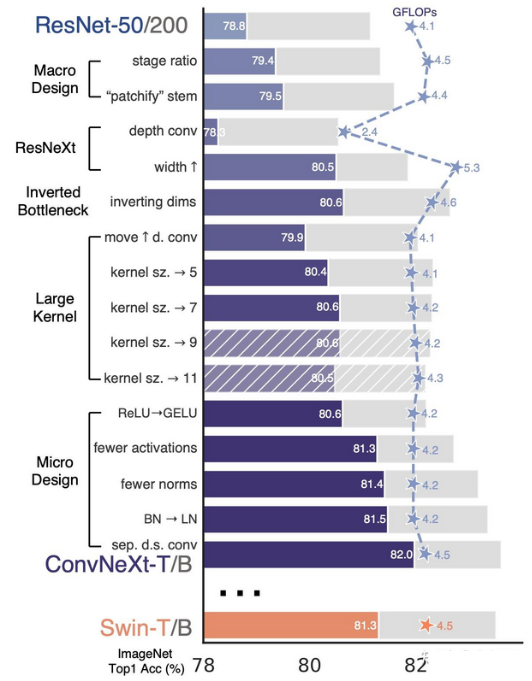

### Pachify

使用一个更大的卷积核（例如14或16）并且卷积核之间不重叠（即步长等于卷积核大小）。这一部分在Swin-Transformer中叫做stem层，它是位于输入之后的一个降采样层。

### GeLU (Gaussian Error Linear Unit)

$ GeLU(x) = x * P(X<=x) = x * Φ(x) = x/2(1+erf(x/√2) ≈ x * sigmoid(1.7x) $  
对比： $ Swish(x) = x*sigmoid(x) $

### Inverted Bottleneck

瓶颈层是一个中间小，两头大的结构，最早在残差网络中被使用。而在MobileNet v2中则使用了一个中间大，两头小的结构，他们认为这个结构能够有效的避免信息流失。之后的 Transformer本质也是一个逆瓶颈层的架构

### DropPath

DropPath randomly drops samples during training with a probability of rate. Note that this layer drops individual samples within a batch and not the entire batch. 

## Official Implementation
https://github.com/facebookresearch/ConvNeXt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.layers import trunc_normal_, DropPath

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf

    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [2]:
def convnext_tiny(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth
    model = ConvNeXt(depths=[3, 3, 9, 3],
                     dims=[96, 192, 384, 768],
                     num_classes=num_classes)
    return model


def convnext_small(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[96, 192, 384, 768],
                     num_classes=num_classes)
    return model


def convnext_base(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth
    # https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[128, 256, 512, 1024],
                     num_classes=num_classes)
    return model


def convnext_large(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth
    # https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[192, 384, 768, 1536],
                     num_classes=num_classes)
    return model


def convnext_xlarge(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[256, 512, 1024, 2048],
                     num_classes=num_classes)
    return model

In [3]:
import os
DATA_DIR = '../data/herb/郁金/'

classes = os.listdir(DATA_DIR)
num_classes = len(classes)
print(classes)

from datetime import datetime
ts = datetime.today().strftime('%Y%m%d%H%M')

# training set : test set = 80% : 20%
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
CONVNEXT_MODEL = 'herb_convnext_'+str((BATCH_SIZE,EPOCHS,LR))+'.pth'

['桂郁金片，广西钦州', '郁金 温郁金 片 浙江温州', '郁金 绿丝郁金片 四川双流', '郁金 黄丝郁金 片 四川崇州']


In [4]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    # transforms.Resize(225),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and validation datasets
full_dataset = ImageFolder(DATA_DIR, transform=transform)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.7, 0.2, 0.1]) 

from torch.utils.data import DataLoader

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
from torchview import draw_graph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

model=convnext_small(num_classes=num_classes).to(device)

model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True) # device='meta', 
model_graph.visual_graph

device:  cuda



(dot.exe:23508): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


In [6]:
from torch import nn, optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, weight_path, LR, EPOCHS):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    best_acc = 0.0

    for epoch in range(EPOCHS):
        print('-' * 30, '\n', f'Epoch: {epoch}/{EPOCHS - 1}')

        # 训练阶段
        model.train()
        running_loss = 0.0
        train_correct_cnt = 0
        for step, (images, labels) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch + 1}', leave=False)):
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            train_correct_cnt += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * train_correct_cnt / len(train_loader.dataset)
        train_accuracies.append(train_accuracy)

        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_correct_cnt = 0

        with torch.no_grad():
            for data_test in val_loader:
                test_images, test_labels = data_test
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                # 前向传播
                outputs = model(test_images)
                loss = loss_function(outputs, test_labels)

                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct_cnt += (predicted.cpu() == test_labels.cpu()).sum().item()

        avg_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * val_correct_cnt / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)

        print(f'Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | '
              f'Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')

        # 保存最好的模型
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model, weight_path)
            print(f'Saved best model with accuracy: {best_acc:.2f}%')

    # 计算并打印平均值
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

    print('\nAverage Metrics:')
    print(f'Average Train Loss: {avg_train_loss:.4f}')
    print(f'Average Validation Loss: {avg_val_loss:.4f}')
    print(f'Average Train Accuracy: {avg_train_accuracy:.2f}%')
    print(f'Average Validation Accuracy: {avg_val_accuracy:.2f}%')

    return model

In [7]:
model=train_model(model, train_loader, val_loader, CONVNEXT_MODEL, LR, EPOCHS)

------------------------------ 
 Epoch: 0/99


Train Loss: 0.0934 | Train Accuracy: 21.43% | Validation Loss: 0.0484 | Validation Accuracy: 27.91%
Saved best model with accuracy: 27.91%
------------------------------ 
 Epoch: 1/99


Train Loss: 0.0454 | Train Accuracy: 27.41% | Validation Loss: 0.0508 | Validation Accuracy: 27.91%
------------------------------ 
 Epoch: 2/99


Train Loss: 0.0460 | Train Accuracy: 25.08% | Validation Loss: 0.0491 | Validation Accuracy: 23.26%
------------------------------ 
 Epoch: 3/99


Train Loss: 0.0442 | Train Accuracy: 29.73% | Validation Loss: 0.0457 | Validation Accuracy: 40.12%
Saved best model with accuracy: 40.12%
------------------------------ 
 Epoch: 4/99


Train Loss: 0.0383 | Train Accuracy: 41.03% | Validation Loss: 0.0363 | Validation Accuracy: 47.09%
Saved best model with accuracy: 47.09%
------------------------------ 
 Epoch: 5/99


Train Loss: 0.0380 | Train Accuracy: 40.37% | Validation Loss: 0.0370 | Validation Accuracy: 36.05%
------------------------------ 
 Epoch: 6/99


Train Loss: 0.0313 | Train Accuracy: 50.00% | Validation Loss: 0.0323 | Validation Accuracy: 53.49%
Saved best model with accuracy: 53.49%
------------------------------ 
 Epoch: 7/99


Train Loss: 0.0297 | Train Accuracy: 54.32% | Validation Loss: 0.0320 | Validation Accuracy: 55.23%
Saved best model with accuracy: 55.23%
------------------------------ 
 Epoch: 8/99


Train Loss: 0.0299 | Train Accuracy: 53.82% | Validation Loss: 0.0309 | Validation Accuracy: 61.63%
Saved best model with accuracy: 61.63%
------------------------------ 
 Epoch: 9/99


Train Loss: 0.0282 | Train Accuracy: 59.14% | Validation Loss: 0.0346 | Validation Accuracy: 56.98%
------------------------------ 
 Epoch: 10/99


Train Loss: 0.0288 | Train Accuracy: 56.15% | Validation Loss: 0.0301 | Validation Accuracy: 63.95%
Saved best model with accuracy: 63.95%
------------------------------ 
 Epoch: 11/99


Train Loss: 0.0276 | Train Accuracy: 59.47% | Validation Loss: 0.0325 | Validation Accuracy: 55.81%
------------------------------ 
 Epoch: 12/99


Train Loss: 0.0274 | Train Accuracy: 60.47% | Validation Loss: 0.0285 | Validation Accuracy: 62.79%
------------------------------ 
 Epoch: 13/99


Train Loss: 0.0276 | Train Accuracy: 59.97% | Validation Loss: 0.0292 | Validation Accuracy: 61.05%
------------------------------ 
 Epoch: 14/99


Train Loss: 0.0270 | Train Accuracy: 60.63% | Validation Loss: 0.0304 | Validation Accuracy: 64.53%
Saved best model with accuracy: 64.53%
------------------------------ 
 Epoch: 15/99


Train Loss: 0.0261 | Train Accuracy: 62.29% | Validation Loss: 0.0285 | Validation Accuracy: 63.95%
------------------------------ 
 Epoch: 16/99


Train Loss: 0.0253 | Train Accuracy: 64.62% | Validation Loss: 0.0274 | Validation Accuracy: 62.79%
------------------------------ 
 Epoch: 17/99


Train Loss: 0.0259 | Train Accuracy: 63.95% | Validation Loss: 0.0310 | Validation Accuracy: 58.14%
------------------------------ 
 Epoch: 18/99


Train Loss: 0.0260 | Train Accuracy: 61.96% | Validation Loss: 0.0290 | Validation Accuracy: 63.95%
------------------------------ 
 Epoch: 19/99


Train Loss: 0.0241 | Train Accuracy: 68.11% | Validation Loss: 0.0282 | Validation Accuracy: 65.70%
Saved best model with accuracy: 65.70%
------------------------------ 
 Epoch: 20/99


Train Loss: 0.0237 | Train Accuracy: 68.27% | Validation Loss: 0.0263 | Validation Accuracy: 63.95%
------------------------------ 
 Epoch: 21/99


Train Loss: 0.0244 | Train Accuracy: 64.78% | Validation Loss: 0.0332 | Validation Accuracy: 52.33%
------------------------------ 
 Epoch: 22/99


Train Loss: 0.0230 | Train Accuracy: 69.10% | Validation Loss: 0.0265 | Validation Accuracy: 65.12%
------------------------------ 
 Epoch: 23/99


Train Loss: 0.0227 | Train Accuracy: 71.43% | Validation Loss: 0.0277 | Validation Accuracy: 70.93%
Saved best model with accuracy: 70.93%
------------------------------ 
 Epoch: 24/99


Train Loss: 0.0231 | Train Accuracy: 68.44% | Validation Loss: 0.0278 | Validation Accuracy: 72.09%
Saved best model with accuracy: 72.09%
------------------------------ 
 Epoch: 25/99


Train Loss: 0.0212 | Train Accuracy: 75.08% | Validation Loss: 0.0277 | Validation Accuracy: 70.93%
------------------------------ 
 Epoch: 26/99


Train Loss: 0.0194 | Train Accuracy: 75.75% | Validation Loss: 0.0392 | Validation Accuracy: 61.63%
------------------------------ 
 Epoch: 27/99


Train Loss: 0.0221 | Train Accuracy: 72.76% | Validation Loss: 0.0240 | Validation Accuracy: 70.93%
------------------------------ 
 Epoch: 28/99


Train Loss: 0.0184 | Train Accuracy: 78.57% | Validation Loss: 0.0260 | Validation Accuracy: 72.09%
------------------------------ 
 Epoch: 29/99


Train Loss: 0.0182 | Train Accuracy: 78.90% | Validation Loss: 0.0249 | Validation Accuracy: 70.35%
------------------------------ 
 Epoch: 30/99


Train Loss: 0.0174 | Train Accuracy: 80.23% | Validation Loss: 0.0295 | Validation Accuracy: 70.35%
------------------------------ 
 Epoch: 31/99


Train Loss: 0.0168 | Train Accuracy: 77.91% | Validation Loss: 0.0255 | Validation Accuracy: 73.26%
Saved best model with accuracy: 73.26%
------------------------------ 
 Epoch: 32/99


Train Loss: 0.0171 | Train Accuracy: 80.23% | Validation Loss: 0.0285 | Validation Accuracy: 69.19%
------------------------------ 
 Epoch: 33/99


Train Loss: 0.0172 | Train Accuracy: 81.23% | Validation Loss: 0.0225 | Validation Accuracy: 75.58%
Saved best model with accuracy: 75.58%
------------------------------ 
 Epoch: 34/99


Train Loss: 0.0161 | Train Accuracy: 82.72% | Validation Loss: 0.0276 | Validation Accuracy: 74.42%
------------------------------ 
 Epoch: 35/99


Train Loss: 0.0156 | Train Accuracy: 81.40% | Validation Loss: 0.0259 | Validation Accuracy: 73.84%
------------------------------ 
 Epoch: 36/99


Train Loss: 0.0150 | Train Accuracy: 82.39% | Validation Loss: 0.0263 | Validation Accuracy: 72.09%
------------------------------ 
 Epoch: 37/99


Train Loss: 0.0140 | Train Accuracy: 84.05% | Validation Loss: 0.0263 | Validation Accuracy: 75.00%
------------------------------ 
 Epoch: 38/99


Train Loss: 0.0148 | Train Accuracy: 83.39% | Validation Loss: 0.0288 | Validation Accuracy: 67.44%
------------------------------ 
 Epoch: 39/99


Train Loss: 0.0177 | Train Accuracy: 79.90% | Validation Loss: 0.0220 | Validation Accuracy: 76.16%
Saved best model with accuracy: 76.16%
------------------------------ 
 Epoch: 40/99


Train Loss: 0.0135 | Train Accuracy: 84.55% | Validation Loss: 0.0217 | Validation Accuracy: 75.58%
------------------------------ 
 Epoch: 41/99


Train Loss: 0.0123 | Train Accuracy: 85.22% | Validation Loss: 0.0243 | Validation Accuracy: 75.58%
------------------------------ 
 Epoch: 42/99


Train Loss: 0.0131 | Train Accuracy: 84.39% | Validation Loss: 0.0339 | Validation Accuracy: 65.70%
------------------------------ 
 Epoch: 43/99


Train Loss: 0.0142 | Train Accuracy: 83.89% | Validation Loss: 0.0282 | Validation Accuracy: 75.58%
------------------------------ 
 Epoch: 44/99


Train Loss: 0.0127 | Train Accuracy: 85.05% | Validation Loss: 0.0213 | Validation Accuracy: 77.91%
Saved best model with accuracy: 77.91%
------------------------------ 
 Epoch: 45/99


Train Loss: 0.0124 | Train Accuracy: 86.54% | Validation Loss: 0.0231 | Validation Accuracy: 76.74%
------------------------------ 
 Epoch: 46/99


Train Loss: 0.0101 | Train Accuracy: 87.71% | Validation Loss: 0.0285 | Validation Accuracy: 74.42%
------------------------------ 
 Epoch: 47/99


Train Loss: 0.0096 | Train Accuracy: 89.87% | Validation Loss: 0.0327 | Validation Accuracy: 75.58%
------------------------------ 
 Epoch: 48/99


Train Loss: 0.0176 | Train Accuracy: 81.56% | Validation Loss: 0.0202 | Validation Accuracy: 79.65%
Saved best model with accuracy: 79.65%
------------------------------ 
 Epoch: 49/99


Train Loss: 0.0153 | Train Accuracy: 83.55% | Validation Loss: 0.0230 | Validation Accuracy: 73.84%
------------------------------ 
 Epoch: 50/99


Train Loss: 0.0109 | Train Accuracy: 88.04% | Validation Loss: 0.0336 | Validation Accuracy: 77.33%
------------------------------ 
 Epoch: 51/99


Train Loss: 0.0121 | Train Accuracy: 86.88% | Validation Loss: 0.0279 | Validation Accuracy: 73.26%
------------------------------ 
 Epoch: 52/99


Train Loss: 0.0103 | Train Accuracy: 87.71% | Validation Loss: 0.0232 | Validation Accuracy: 77.91%
------------------------------ 
 Epoch: 53/99


Train Loss: 0.0096 | Train Accuracy: 88.37% | Validation Loss: 0.0278 | Validation Accuracy: 72.67%
------------------------------ 
 Epoch: 54/99


Train Loss: 0.0088 | Train Accuracy: 91.03% | Validation Loss: 0.0315 | Validation Accuracy: 75.00%
------------------------------ 
 Epoch: 55/99


Train Loss: 0.0090 | Train Accuracy: 91.03% | Validation Loss: 0.0366 | Validation Accuracy: 72.67%
------------------------------ 
 Epoch: 56/99


Train Loss: 0.0086 | Train Accuracy: 91.36% | Validation Loss: 0.0272 | Validation Accuracy: 73.84%
------------------------------ 
 Epoch: 57/99


Train Loss: 0.0086 | Train Accuracy: 91.69% | Validation Loss: 0.0334 | Validation Accuracy: 71.51%
------------------------------ 
 Epoch: 58/99


Train Loss: 0.0086 | Train Accuracy: 90.86% | Validation Loss: 0.0318 | Validation Accuracy: 74.42%
------------------------------ 
 Epoch: 59/99


Train Loss: 0.0078 | Train Accuracy: 91.53% | Validation Loss: 0.0296 | Validation Accuracy: 76.16%
------------------------------ 
 Epoch: 60/99


Train Loss: 0.0094 | Train Accuracy: 89.87% | Validation Loss: 0.0299 | Validation Accuracy: 76.74%
------------------------------ 
 Epoch: 61/99


Train Loss: 0.0071 | Train Accuracy: 93.36% | Validation Loss: 0.0297 | Validation Accuracy: 73.84%
------------------------------ 
 Epoch: 62/99


Train Loss: 0.0057 | Train Accuracy: 94.68% | Validation Loss: 0.0285 | Validation Accuracy: 78.49%
------------------------------ 
 Epoch: 63/99


Train Loss: 0.0056 | Train Accuracy: 95.02% | Validation Loss: 0.0402 | Validation Accuracy: 73.84%
------------------------------ 
 Epoch: 64/99


Train Loss: 0.0058 | Train Accuracy: 94.85% | Validation Loss: 0.0499 | Validation Accuracy: 69.77%
------------------------------ 
 Epoch: 65/99


Train Loss: 0.0104 | Train Accuracy: 89.04% | Validation Loss: 0.0310 | Validation Accuracy: 71.51%
------------------------------ 
 Epoch: 66/99


Train Loss: 0.0063 | Train Accuracy: 93.36% | Validation Loss: 0.0354 | Validation Accuracy: 72.67%
------------------------------ 
 Epoch: 67/99


Train Loss: 0.0077 | Train Accuracy: 91.53% | Validation Loss: 0.0311 | Validation Accuracy: 77.33%
------------------------------ 
 Epoch: 68/99


Train Loss: 0.0080 | Train Accuracy: 91.20% | Validation Loss: 0.0340 | Validation Accuracy: 75.58%
------------------------------ 
 Epoch: 69/99


Train Loss: 0.0065 | Train Accuracy: 92.86% | Validation Loss: 0.0295 | Validation Accuracy: 75.00%
------------------------------ 
 Epoch: 70/99


Train Loss: 0.0050 | Train Accuracy: 94.52% | Validation Loss: 0.0337 | Validation Accuracy: 77.91%
------------------------------ 
 Epoch: 71/99


Train Loss: 0.0105 | Train Accuracy: 89.20% | Validation Loss: 0.0278 | Validation Accuracy: 78.49%
------------------------------ 
 Epoch: 72/99


Train Loss: 0.0079 | Train Accuracy: 90.86% | Validation Loss: 0.0289 | Validation Accuracy: 75.00%
------------------------------ 
 Epoch: 73/99


Train Loss: 0.0056 | Train Accuracy: 94.35% | Validation Loss: 0.0346 | Validation Accuracy: 73.26%
------------------------------ 
 Epoch: 74/99


Train Loss: 0.0070 | Train Accuracy: 91.20% | Validation Loss: 0.0395 | Validation Accuracy: 72.09%
------------------------------ 
 Epoch: 75/99


Train Loss: 0.0086 | Train Accuracy: 90.37% | Validation Loss: 0.0333 | Validation Accuracy: 73.26%
------------------------------ 
 Epoch: 76/99


Train Loss: 0.0071 | Train Accuracy: 92.52% | Validation Loss: 0.0304 | Validation Accuracy: 77.91%
------------------------------ 
 Epoch: 77/99


Train Loss: 0.0050 | Train Accuracy: 95.68% | Validation Loss: 0.0418 | Validation Accuracy: 72.67%
------------------------------ 
 Epoch: 78/99


Train Loss: 0.0041 | Train Accuracy: 95.85% | Validation Loss: 0.0286 | Validation Accuracy: 76.74%
------------------------------ 
 Epoch: 79/99


Train Loss: 0.0042 | Train Accuracy: 95.85% | Validation Loss: 0.0341 | Validation Accuracy: 77.33%
------------------------------ 
 Epoch: 80/99


Train Loss: 0.0056 | Train Accuracy: 95.02% | Validation Loss: 0.0554 | Validation Accuracy: 69.19%
------------------------------ 
 Epoch: 81/99


Train Loss: 0.0072 | Train Accuracy: 92.86% | Validation Loss: 0.0402 | Validation Accuracy: 73.84%
------------------------------ 
 Epoch: 82/99


Train Loss: 0.0048 | Train Accuracy: 95.51% | Validation Loss: 0.0318 | Validation Accuracy: 75.58%
------------------------------ 
 Epoch: 83/99


Train Loss: 0.0050 | Train Accuracy: 95.02% | Validation Loss: 0.0387 | Validation Accuracy: 76.16%
------------------------------ 
 Epoch: 84/99


Train Loss: 0.0050 | Train Accuracy: 94.68% | Validation Loss: 0.0527 | Validation Accuracy: 71.51%
------------------------------ 
 Epoch: 85/99


Train Loss: 0.0053 | Train Accuracy: 95.02% | Validation Loss: 0.0382 | Validation Accuracy: 73.26%
------------------------------ 
 Epoch: 86/99


Train Loss: 0.0033 | Train Accuracy: 96.84% | Validation Loss: 0.0397 | Validation Accuracy: 73.26%
------------------------------ 
 Epoch: 87/99


Train Loss: 0.0024 | Train Accuracy: 98.34% | Validation Loss: 0.0372 | Validation Accuracy: 74.42%
------------------------------ 
 Epoch: 88/99


Train Loss: 0.0019 | Train Accuracy: 98.50% | Validation Loss: 0.0397 | Validation Accuracy: 75.58%
------------------------------ 
 Epoch: 89/99


Train Loss: 0.0015 | Train Accuracy: 98.34% | Validation Loss: 0.0555 | Validation Accuracy: 73.26%
------------------------------ 
 Epoch: 90/99


Train Loss: 0.0021 | Train Accuracy: 98.50% | Validation Loss: 0.0478 | Validation Accuracy: 72.09%
------------------------------ 
 Epoch: 91/99


Train Loss: 0.0092 | Train Accuracy: 90.20% | Validation Loss: 0.0493 | Validation Accuracy: 68.60%
------------------------------ 
 Epoch: 92/99


Train Loss: 0.0066 | Train Accuracy: 92.86% | Validation Loss: 0.0322 | Validation Accuracy: 77.33%
------------------------------ 
 Epoch: 93/99


Train Loss: 0.0036 | Train Accuracy: 96.84% | Validation Loss: 0.0436 | Validation Accuracy: 73.84%
------------------------------ 
 Epoch: 94/99


Train Loss: 0.0027 | Train Accuracy: 97.51% | Validation Loss: 0.0318 | Validation Accuracy: 76.74%
------------------------------ 
 Epoch: 95/99


Train Loss: 0.0022 | Train Accuracy: 97.67% | Validation Loss: 0.0404 | Validation Accuracy: 76.74%
------------------------------ 
 Epoch: 96/99


Train Loss: 0.0020 | Train Accuracy: 98.34% | Validation Loss: 0.0470 | Validation Accuracy: 74.42%
------------------------------ 
 Epoch: 97/99


Train Loss: 0.0036 | Train Accuracy: 96.18% | Validation Loss: 0.0591 | Validation Accuracy: 69.19%
------------------------------ 
 Epoch: 98/99


Train Loss: 0.0086 | Train Accuracy: 91.53% | Validation Loss: 0.0300 | Validation Accuracy: 73.26%
------------------------------ 
 Epoch: 99/99


Train Loss: 0.0045 | Train Accuracy: 95.35% | Validation Loss: 0.0301 | Validation Accuracy: 72.09%

Average Metrics:
Average Train Loss: 0.0152
Average Validation Loss: 0.0331
Average Train Accuracy: 80.79%
Average Validation Accuracy: 69.15%
